# Model Explainability Analysis - SHAP

This notebook analyzes the champion model using SHAP (SHapley Additive exPlanations):
- Global feature importance
- Local explanations for individual predictions
- Business insights from model decisions

## 1. Setup and Imports

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import joblib
import mlflow

# Import custom modules
from explainability import *
from metrics import *

print("All imports successful!")
print(f"SHAP version: {shap.__version__}")

All imports successful!
SHAP version: 0.50.0


## 2. Load Champion Model

In [2]:
# Load the comparison results to identify champion
comparison_df = pd.read_csv('../reports/model_comparison.csv')
best_model_idx = comparison_df['Business Cost'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"Champion Model: {best_model_name}")
print(f"Business Cost: {comparison_df.loc[best_model_idx, 'Business Cost']:.2f}")
print(f"AUC: {comparison_df.loc[best_model_idx, 'AUC']:.4f}")

# Map model name to file
model_files = {
    'Logistic Regression': 'logistic_regression.pkl',
    'Random Forest': 'random_forest.pkl',
    'XGBoost': 'xgboost.pkl',
    'LightGBM': 'lightgbm.pkl'
}

model_file = model_files[best_model_name]
model = joblib.load(f'../models/{model_file}')
print(f"\nModel loaded from ../models/{model_file}")

Champion Model: LightGBM
Business Cost: 4959.00
AUC: 0.7793

Model loaded from ../models/lightgbm.pkl


## 3. Load Test Data

In [3]:
# Load prepared data
df = pd.read_csv('../data/application_train_prepared.csv')

# Separate features and target
if 'TARGET' in df.columns:
    target_col = 'TARGET'
else:
    target_col = [col for col in df.columns if 'target' in col.lower()][0]

X = df.drop(columns=[target_col])
y = df[target_col]

# Use same split as training notebook
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Test set size: {X_test.shape[0]:,}")
print(f"Number of features: {X_test.shape[1]:,}")

Test set size: 61,503
Number of features: 335


## 4. Sample Data for SHAP (Performance)

In [4]:
# Sample for performance (SHAP can be slow on large datasets)
sample_size = min(1000, X_test.shape[0])
X_test_sample = X_test.sample(n=sample_size, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

print(f"Using {sample_size} samples for SHAP analysis")

Using 1000 samples for SHAP analysis


## 5. Create SHAP Explainer

In [5]:
# Create appropriate explainer based on model type
if best_model_name == 'Logistic Regression':
    # For linear models
    explainer = shap.LinearExplainer(model, X_train)
else:
    # For tree-based models (RF, XGB, LGB)
    explainer = shap.TreeExplainer(model)

print(f"SHAP Explainer created for {best_model_name}")

SHAP Explainer created for LightGBM


## 6. Calculate SHAP Values

In [6]:
# Calculate SHAP values
print("Calculating SHAP values... (this may take a few minutes)")
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, some explainers return values for both classes
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class

print(f"SHAP values shape: {shap_values.shape}")
print("SHAP calculation complete!")

Calculating SHAP values... (this may take a few minutes)
SHAP values shape: (1000, 335)
SHAP calculation complete!


## 7. Global Feature Importance - Summary Plot

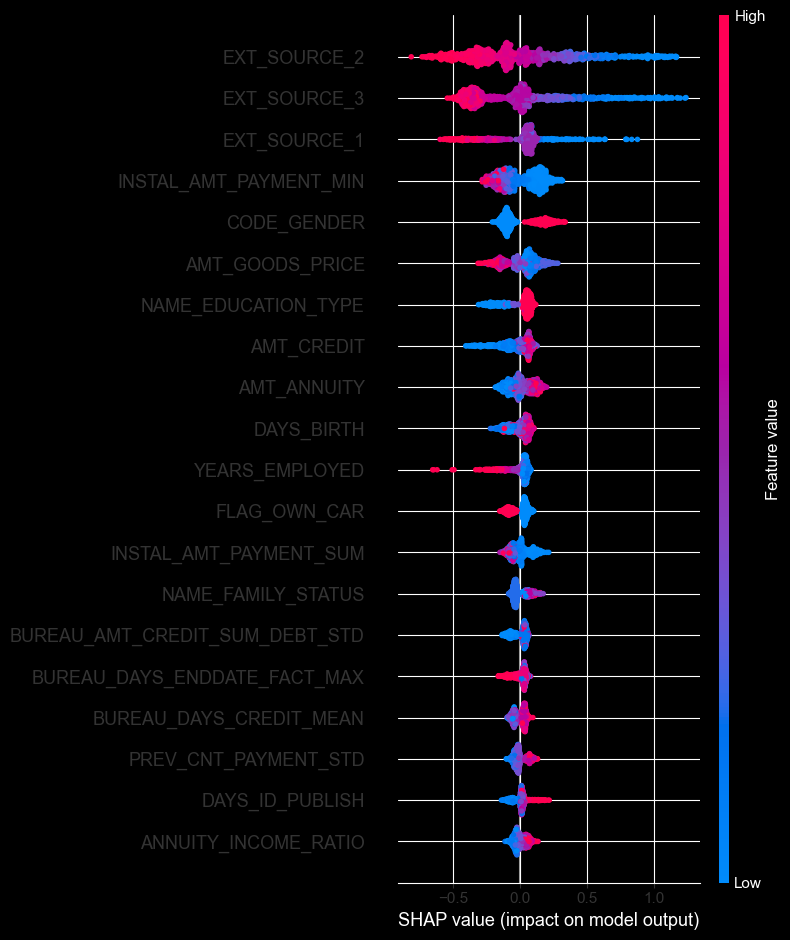

SHAP summary plot saved to ../reports/figures/shap_summary.png


In [7]:
# SHAP Summary Plot (beeswarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False, max_display=20)
plt.tight_layout()
os.makedirs('../reports/figures', exist_ok=True)
plt.savefig('../reports/figures/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP summary plot saved to ../reports/figures/shap_summary.png")

## 8. Global Feature Importance - Bar Plot

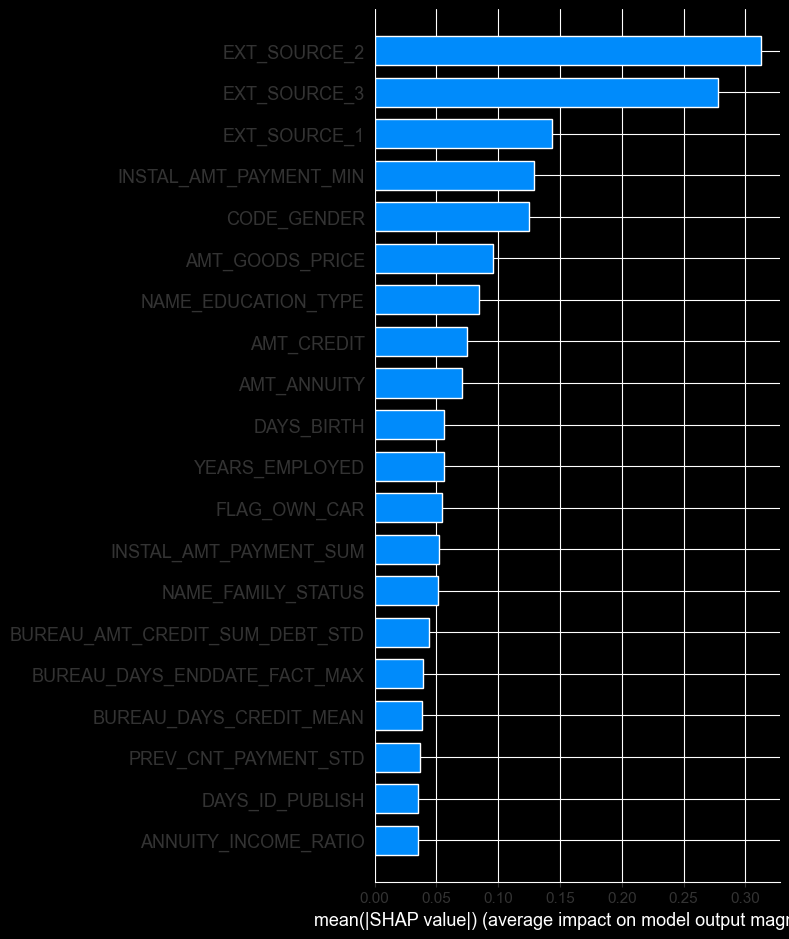

SHAP importance plot saved to ../reports/figures/shap_importance.png


In [8]:
# SHAP Bar Plot (mean absolute SHAP values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type='bar', show=False, max_display=20)
plt.tight_layout()
plt.savefig('../reports/figures/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP importance plot saved to ../reports/figures/shap_importance.png")

## 9. Top 20 Most Important Features

In [9]:
# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (by mean |SHAP value|):")
print("="*60)
print(feature_importance.head(20).to_string(index=False))
print("="*60)


Top 20 Most Important Features (by mean |SHAP value|):
                       feature  importance
                  EXT_SOURCE_2    0.312436
                  EXT_SOURCE_3    0.278228
                  EXT_SOURCE_1    0.143731
        INSTAL_AMT_PAYMENT_MIN    0.128908
                   CODE_GENDER    0.124902
               AMT_GOODS_PRICE    0.095463
           NAME_EDUCATION_TYPE    0.084617
                    AMT_CREDIT    0.074601
                   AMT_ANNUITY    0.070709
                    DAYS_BIRTH    0.056200
                YEARS_EMPLOYED    0.055807
                  FLAG_OWN_CAR    0.054234
        INSTAL_AMT_PAYMENT_SUM    0.052162
            NAME_FAMILY_STATUS    0.050998
BUREAU_AMT_CREDIT_SUM_DEBT_STD    0.043955
  BUREAU_DAYS_ENDDATE_FACT_MAX    0.038919
       BUREAU_DAYS_CREDIT_MEAN    0.038669
          PREV_CNT_PAYMENT_STD    0.036489
               DAYS_ID_PUBLISH    0.035503
          ANNUITY_INCOME_RATIO    0.034925


## 10. Feature Impact Analysis

In [10]:
# Analyze which features increase vs decrease default risk
print("\nFeature Impact Analysis:")
print("="*60)

top_features = feature_importance.head(10)['feature'].tolist()

for feature in top_features:
    feature_idx = X_test_sample.columns.get_loc(feature)
    mean_shap = shap_values[:, feature_idx].mean()
    
    if mean_shap > 0:
        direction = "INCREASES default risk"
    else:
        direction = "DECREASES default risk"
    
    print(f"{feature:40s} -> {direction} (mean SHAP: {mean_shap:+.4f})")

print("="*60)


Feature Impact Analysis:
EXT_SOURCE_2                             -> INCREASES default risk (mean SHAP: +0.0084)
EXT_SOURCE_3                             -> DECREASES default risk (mean SHAP: -0.0156)
EXT_SOURCE_1                             -> INCREASES default risk (mean SHAP: +0.0013)
INSTAL_AMT_PAYMENT_MIN                   -> DECREASES default risk (mean SHAP: -0.0017)
CODE_GENDER                              -> DECREASES default risk (mean SHAP: -0.0147)
AMT_GOODS_PRICE                          -> INCREASES default risk (mean SHAP: +0.0139)
NAME_EDUCATION_TYPE                      -> INCREASES default risk (mean SHAP: +0.0019)
AMT_CREDIT                               -> DECREASES default risk (mean SHAP: -0.0195)
AMT_ANNUITY                              -> INCREASES default risk (mean SHAP: +0.0071)
DAYS_BIRTH                               -> DECREASES default risk (mean SHAP: -0.0003)


## 11. Business Interpretation

### Key Insights:

Based on the SHAP analysis above:

1. **External Data Sources** (EXT_SOURCE_X): Often the most predictive features
2. **Credit Amount**: Higher loan amounts may correlate with risk
3. **Age/Employment**: Client stability indicators
4. **Previous Credit History**: Strong predictor of future behavior

These insights should guide:
- Which data to prioritize collecting
- What to monitor in production
- How to explain decisions to stakeholders

## 12. Select Interesting Clients for Local Analysis

In [11]:
# Get predictions
y_pred_proba = model.predict_proba(X_test_sample)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Find interesting cases
true_positives = X_test_sample[(y_test_sample == 1) & (y_pred == 1)].index
true_negatives = X_test_sample[(y_test_sample == 0) & (y_pred == 0)].index
false_positives = X_test_sample[(y_test_sample == 0) & (y_pred == 1)].index
false_negatives = X_test_sample[(y_test_sample == 1) & (y_pred == 0)].index

# Edge cases (probability near 0.5)
edge_cases = X_test_sample[(y_pred_proba > 0.45) & (y_pred_proba < 0.55)].index

# Select one of each
interesting_clients = []
interesting_labels = []

if len(true_positives) > 0:
    interesting_clients.append(true_positives[0])
    interesting_labels.append('True Positive (Correct Default Prediction)')

if len(true_negatives) > 0:
    interesting_clients.append(true_negatives[0])
    interesting_labels.append('True Negative (Correct Non-Default Prediction)')

if len(false_positives) > 0:
    interesting_clients.append(false_positives[0])
    interesting_labels.append('False Positive (Conservative Error)')

if len(false_negatives) > 0:
    interesting_clients.append(false_negatives[0])
    interesting_labels.append('False Negative (Costly Error)')

if len(edge_cases) > 0:
    interesting_clients.append(edge_cases[0])
    interesting_labels.append('Edge Case (Probability ~0.5)')

print(f"Selected {len(interesting_clients)} interesting clients for local analysis")

Selected 5 interesting clients for local analysis


## 13. Local Explanations - Waterfall Plots


Client Analysis: True Positive (Correct Default Prediction)
Actual: 1 | Predicted: 1 | Probability: 0.8223


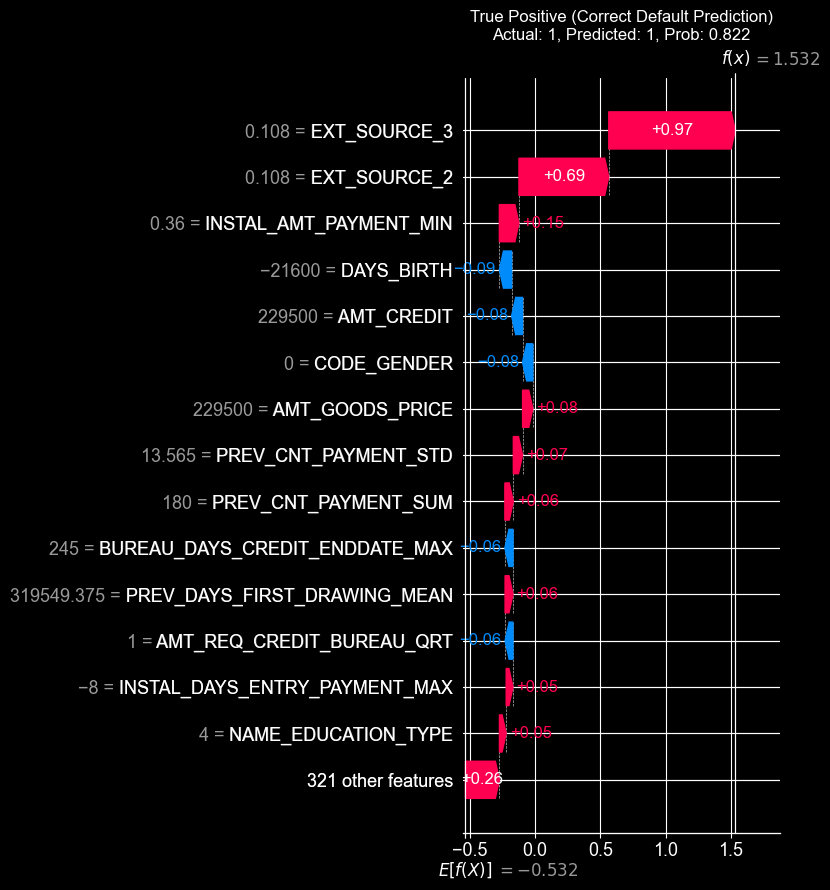


Top 10 Contributing Features:
  EXT_SOURCE_3                        =       0.11  (SHAP: +0.9674)
  EXT_SOURCE_2                        =       0.11  (SHAP: +0.6872)
  INSTAL_AMT_PAYMENT_MIN              =       0.36  (SHAP: +0.1499)
  DAYS_BIRTH                          =  -21600.00  (SHAP: -0.0936)
  AMT_CREDIT                          =  229500.00  (SHAP: -0.0837)
  CODE_GENDER                         =       0.00  (SHAP: -0.0788)
  AMT_GOODS_PRICE                     =  229500.00  (SHAP: +0.0787)
  PREV_CNT_PAYMENT_STD                =      13.56  (SHAP: +0.0706)
  PREV_CNT_PAYMENT_SUM                =     180.00  (SHAP: +0.0648)
  BUREAU_DAYS_CREDIT_ENDDATE_MAX      =     245.00  (SHAP: -0.0627)

Client Analysis: True Negative (Correct Non-Default Prediction)
Actual: 0 | Predicted: 0 | Probability: 0.4628


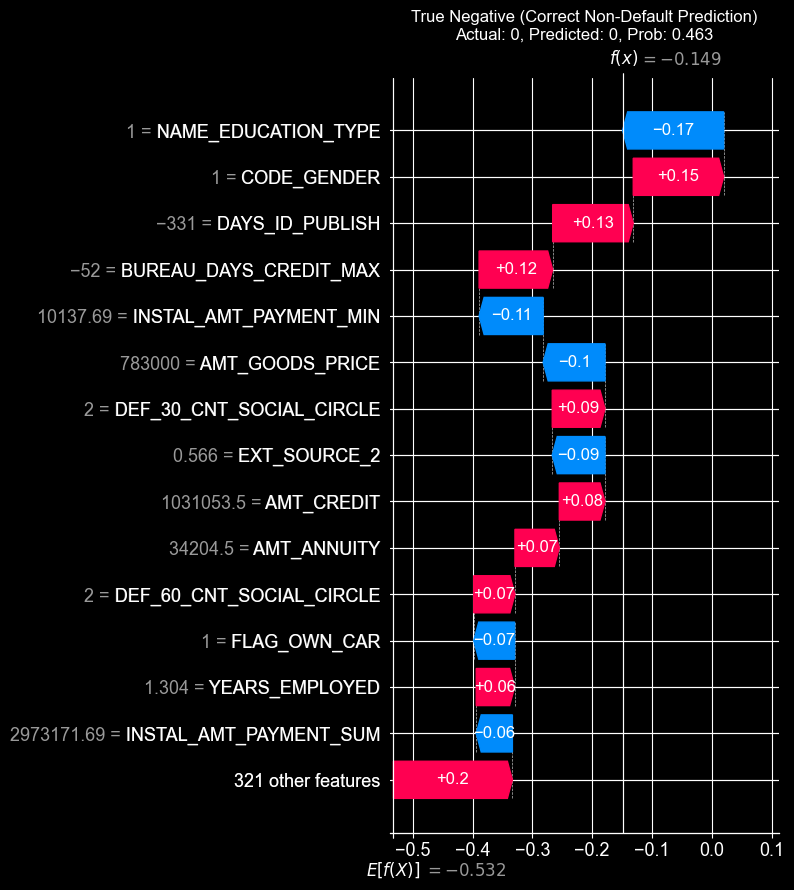


Top 10 Contributing Features:
  NAME_EDUCATION_TYPE                 =       1.00  (SHAP: -0.1690)
  CODE_GENDER                         =       1.00  (SHAP: +0.1512)
  DAYS_ID_PUBLISH                     =    -331.00  (SHAP: +0.1347)
  BUREAU_DAYS_CREDIT_MAX              =     -52.00  (SHAP: +0.1230)
  INSTAL_AMT_PAYMENT_MIN              =   10137.69  (SHAP: -0.1071)
  AMT_GOODS_PRICE                     =  783000.00  (SHAP: -0.1035)
  DEF_30_CNT_SOCIAL_CIRCLE            =       2.00  (SHAP: +0.0883)
  EXT_SOURCE_2                        =       0.57  (SHAP: -0.0882)
  AMT_CREDIT                          = 1031053.50  (SHAP: +0.0764)
  AMT_ANNUITY                         =   34204.50  (SHAP: +0.0742)

Client Analysis: False Positive (Conservative Error)
Actual: 0 | Predicted: 1 | Probability: 0.8219


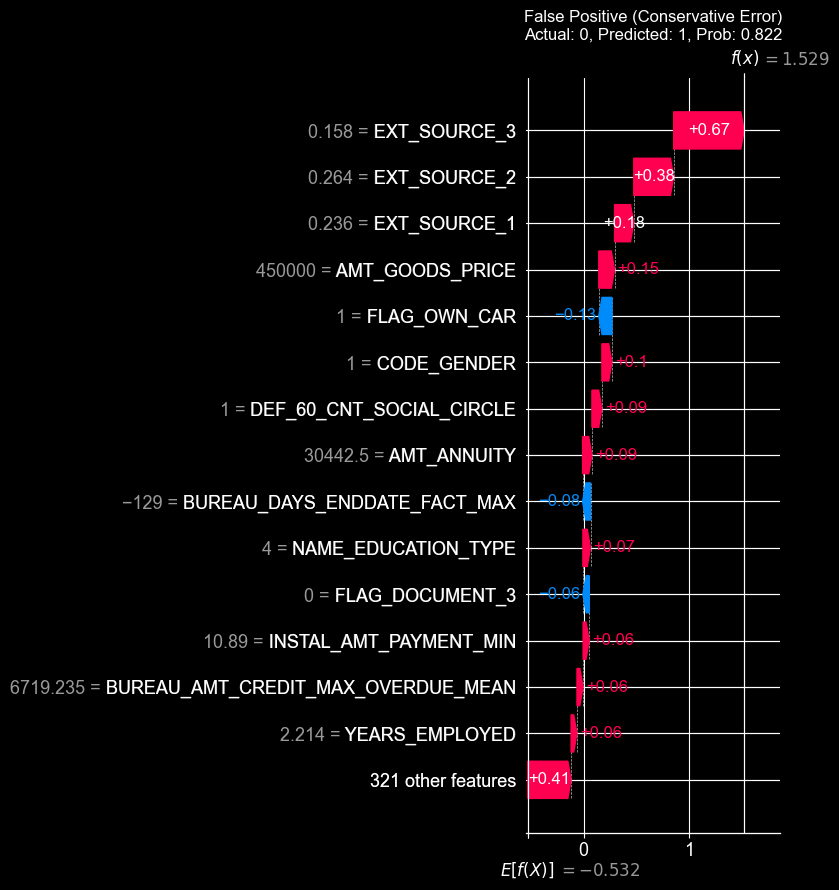


Top 10 Contributing Features:
  EXT_SOURCE_3                        =       0.16  (SHAP: +0.6716)
  EXT_SOURCE_2                        =       0.26  (SHAP: +0.3804)
  EXT_SOURCE_1                        =       0.24  (SHAP: +0.1829)
  AMT_GOODS_PRICE                     =  450000.00  (SHAP: +0.1506)
  FLAG_OWN_CAR                        =       1.00  (SHAP: -0.1257)
  CODE_GENDER                         =       1.00  (SHAP: +0.0960)
  DEF_60_CNT_SOCIAL_CIRCLE            =       1.00  (SHAP: +0.0950)
  AMT_ANNUITY                         =   30442.50  (SHAP: +0.0891)
  BUREAU_DAYS_ENDDATE_FACT_MAX        =    -129.00  (SHAP: -0.0754)
  NAME_EDUCATION_TYPE                 =       4.00  (SHAP: +0.0725)

Client Analysis: False Negative (Costly Error)
Actual: 1 | Predicted: 0 | Probability: 0.3518


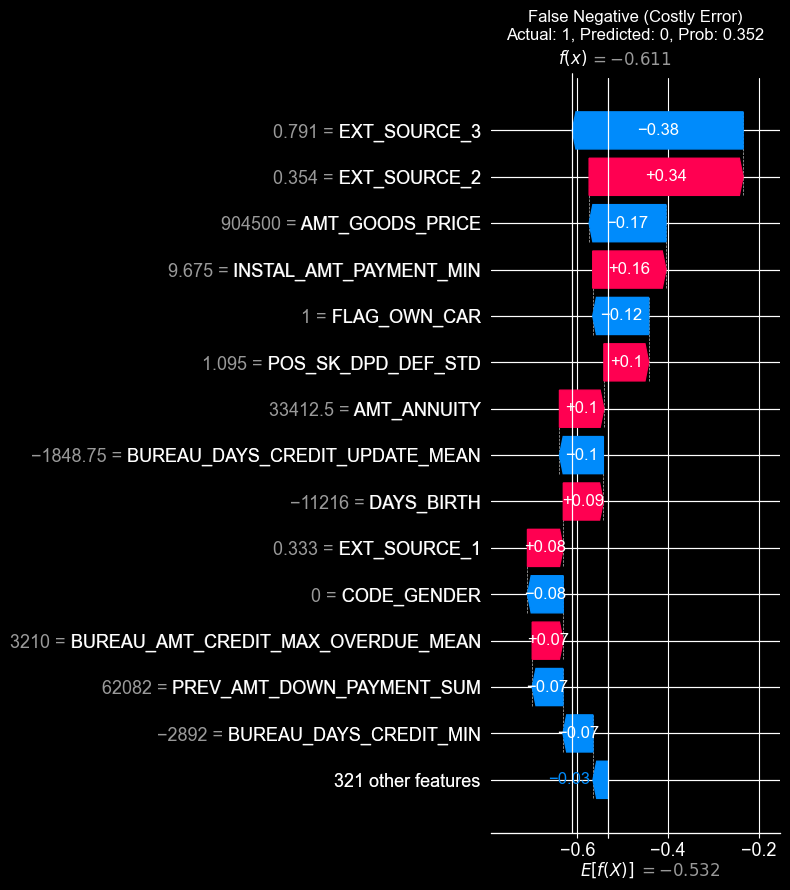


Top 10 Contributing Features:
  EXT_SOURCE_3                        =       0.79  (SHAP: -0.3772)
  EXT_SOURCE_2                        =       0.35  (SHAP: +0.3399)
  AMT_GOODS_PRICE                     =  904500.00  (SHAP: -0.1697)
  INSTAL_AMT_PAYMENT_MIN              =       9.68  (SHAP: +0.1617)
  FLAG_OWN_CAR                        =       1.00  (SHAP: -0.1236)
  POS_SK_DPD_DEF_STD                  =       1.10  (SHAP: +0.0990)
  AMT_ANNUITY                         =   33412.50  (SHAP: +0.0980)
  BUREAU_DAYS_CREDIT_UPDATE_MEAN      =   -1848.75  (SHAP: -0.0969)
  DAYS_BIRTH                          =  -11216.00  (SHAP: +0.0884)
  EXT_SOURCE_1                        =       0.33  (SHAP: +0.0791)

Client Analysis: Edge Case (Probability ~0.5)
Actual: 0 | Predicted: 0 | Probability: 0.4628


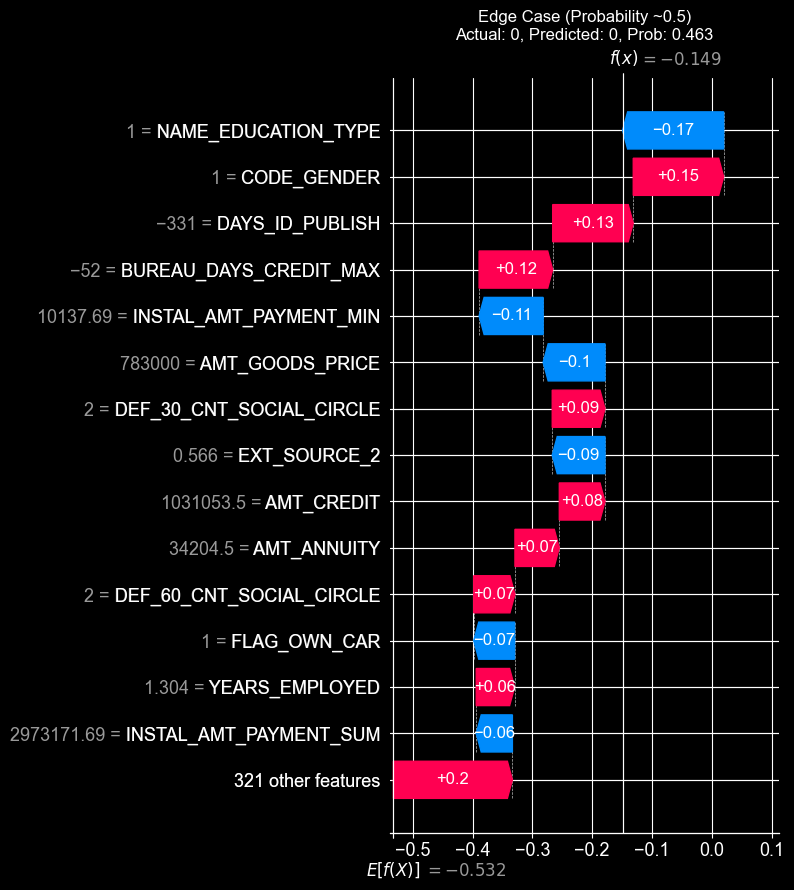


Top 10 Contributing Features:
  NAME_EDUCATION_TYPE                 =       1.00  (SHAP: -0.1690)
  CODE_GENDER                         =       1.00  (SHAP: +0.1512)
  DAYS_ID_PUBLISH                     =    -331.00  (SHAP: +0.1347)
  BUREAU_DAYS_CREDIT_MAX              =     -52.00  (SHAP: +0.1230)
  INSTAL_AMT_PAYMENT_MIN              =   10137.69  (SHAP: -0.1071)
  AMT_GOODS_PRICE                     =  783000.00  (SHAP: -0.1035)
  DEF_30_CNT_SOCIAL_CIRCLE            =       2.00  (SHAP: +0.0883)
  EXT_SOURCE_2                        =       0.57  (SHAP: -0.0882)
  AMT_CREDIT                          = 1031053.50  (SHAP: +0.0764)
  AMT_ANNUITY                         =   34204.50  (SHAP: +0.0742)


In [12]:
# Create waterfall plot for each interesting client
for idx, (client_idx, label) in enumerate(zip(interesting_clients, interesting_labels)):
    print(f"\n{'='*80}")
    print(f"Client Analysis: {label}")
    print(f"{'='*80}")
    
    # Get client position in sample
    client_pos = X_test_sample.index.get_loc(client_idx)
    
    # Client info
    actual = y_test_sample.loc[client_idx]
    predicted_proba = y_pred_proba[client_pos]
    predicted = y_pred[client_pos]
    
    print(f"Actual: {actual} | Predicted: {predicted} | Probability: {predicted_proba:.4f}")
    
    # Waterfall plot
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[client_pos],
            base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
            data=X_test_sample.iloc[client_pos],
            feature_names=X_test_sample.columns.tolist()
        ),
        max_display=15,
        show=False
    )
    plt.title(f"{label}\nActual: {actual}, Predicted: {predicted}, Prob: {predicted_proba:.3f}")
    plt.tight_layout()
    plt.savefig(f'../reports/figures/shap_waterfall_client_{idx+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Top contributing features
    client_shap = shap_values[client_pos]
    top_features_idx = np.argsort(np.abs(client_shap))[-10:][::-1]
    
    print(f"\nTop 10 Contributing Features:")
    for feat_idx in top_features_idx:
        feat_name = X_test_sample.columns[feat_idx]
        feat_value = X_test_sample.iloc[client_pos, feat_idx]
        shap_val = client_shap[feat_idx]
        print(f"  {feat_name:35s} = {feat_value:10.2f}  (SHAP: {shap_val:+.4f})")

## 14. Create Complete Explainability Report

Generating complete explainability report...
Création du rapport d'explicabilité...
Explainer SHAP créé pour LGBMClassifier

Calcul des valeurs SHAP...

Génération du summary plot...
Figure SHAP summary sauvegardée dans ../reports/figures/shap_global.png


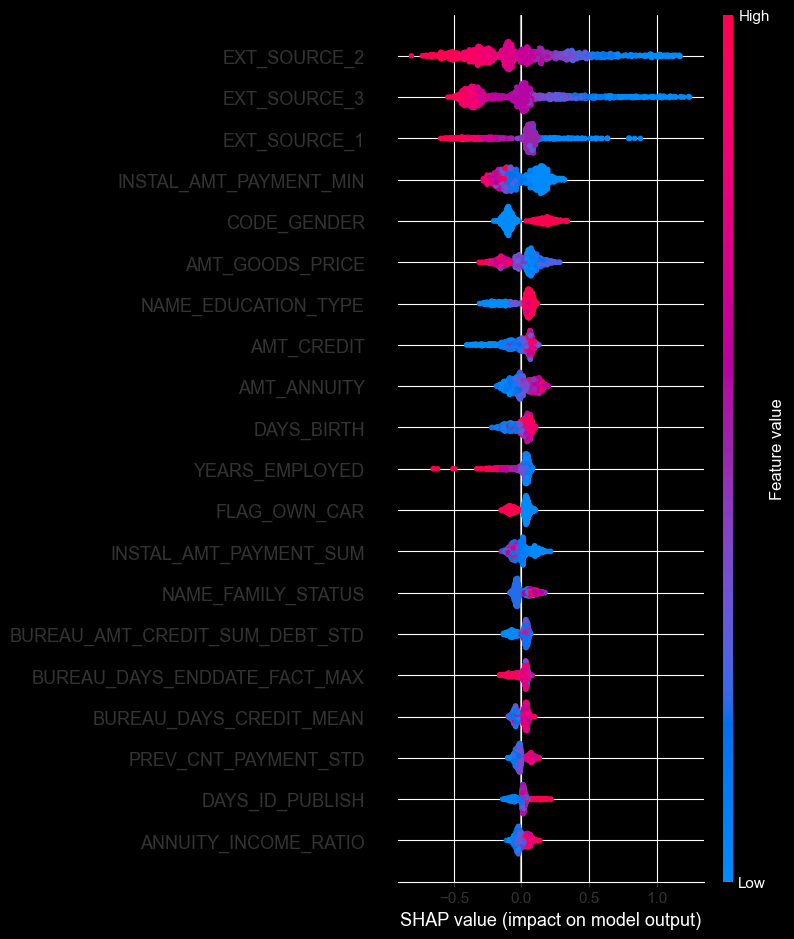


Génération du bar plot...
Figure SHAP bar sauvegardée dans ../reports/figures/shap_bar.png


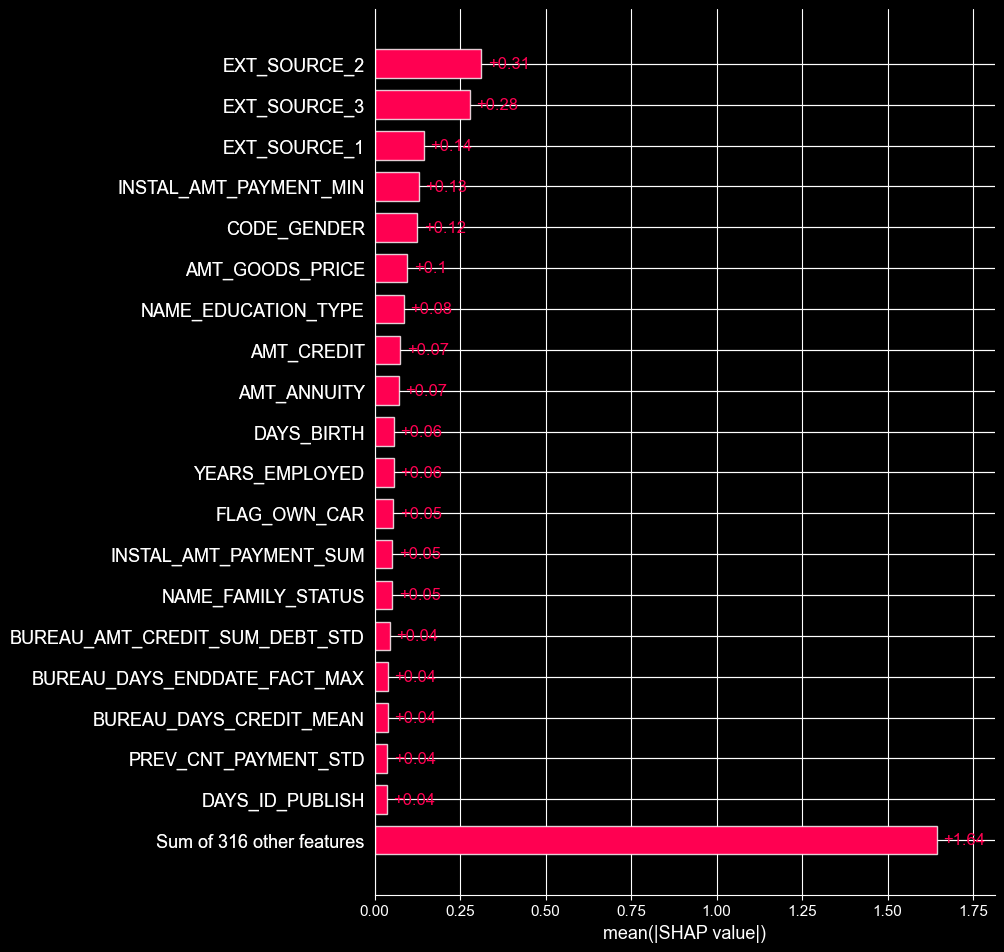


Explication locale pour le client 0...
Figure SHAP waterfall sauvegardée dans ../reports/figures/shap_local_client_0.png


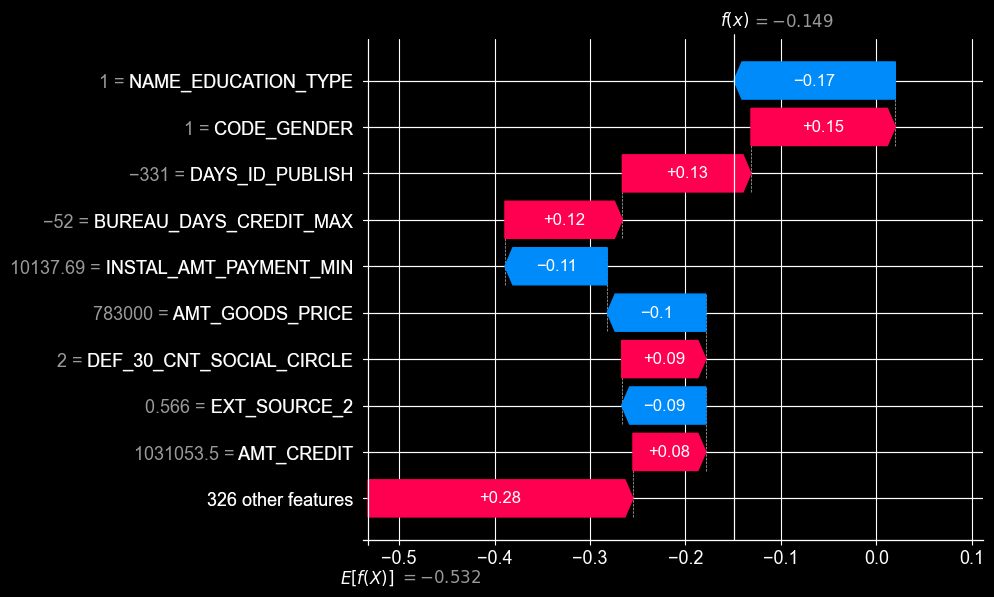

EXPLICATION DE LA PRÉDICTION - Client 0
Prédiction: Pas de défaut
Probabilité de défaut: 0.4628

Top 10 features influençant la prédiction:
------------------------------------------------------------
NAME_EDUCATION_TYPE            =       1.00
  Impact SHAP: -0.1690 ↓ Diminue le risque

CODE_GENDER                    =       1.00
  Impact SHAP: +0.1512 ↑ Augmente le risque

DAYS_ID_PUBLISH                =    -331.00
  Impact SHAP: +0.1347 ↑ Augmente le risque

BUREAU_DAYS_CREDIT_MAX         =     -52.00
  Impact SHAP: +0.1230 ↑ Augmente le risque

INSTAL_AMT_PAYMENT_MIN         =   10137.69
  Impact SHAP: -0.1071 ↓ Diminue le risque

AMT_GOODS_PRICE                =  783000.00
  Impact SHAP: -0.1035 ↓ Diminue le risque

DEF_30_CNT_SOCIAL_CIRCLE       =       2.00
  Impact SHAP: +0.0883 ↑ Augmente le risque

EXT_SOURCE_2                   =       0.57
  Impact SHAP: -0.0882 ↓ Diminue le risque

AMT_CREDIT                     = 1031053.50
  Impact SHAP: +0.0764 ↑ Augmente le risque

AM

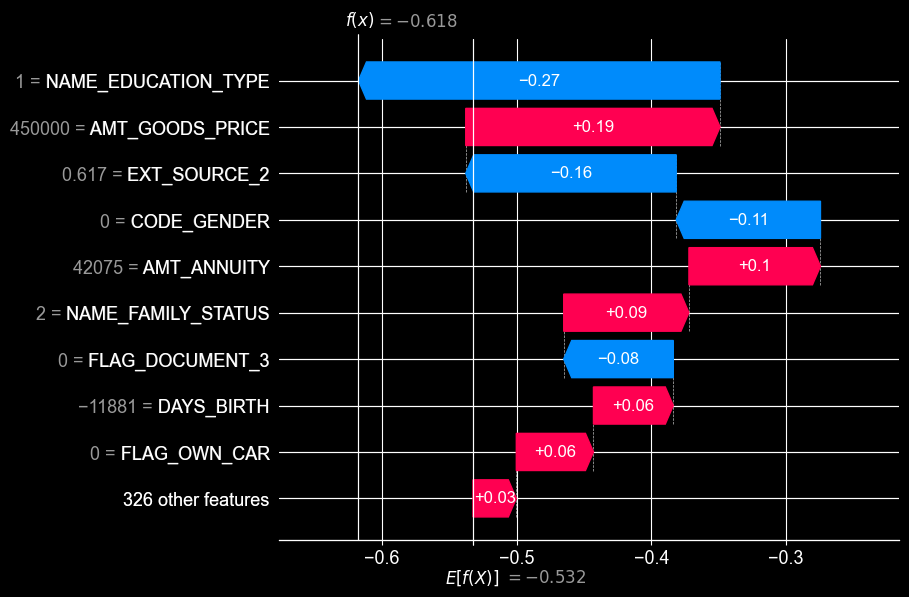

EXPLICATION DE LA PRÉDICTION - Client 1
Prédiction: Pas de défaut
Probabilité de défaut: 0.3503

Top 10 features influençant la prédiction:
------------------------------------------------------------
NAME_EDUCATION_TYPE            =       1.00
  Impact SHAP: -0.2687 ↓ Diminue le risque

AMT_GOODS_PRICE                =  783000.00
  Impact SHAP: +0.1890 ↑ Augmente le risque

EXT_SOURCE_2                   =       0.57
  Impact SHAP: -0.1564 ↓ Diminue le risque

CODE_GENDER                    =       1.00
  Impact SHAP: -0.1072 ↓ Diminue le risque

AMT_ANNUITY                    =   34204.50
  Impact SHAP: +0.0978 ↑ Augmente le risque

NAME_FAMILY_STATUS             =       1.00
  Impact SHAP: +0.0931 ↑ Augmente le risque

FLAG_DOCUMENT_3                =       1.00
  Impact SHAP: -0.0814 ↓ Diminue le risque

DAYS_BIRTH                     =  -17143.00
  Impact SHAP: +0.0593 ↑ Augmente le risque

FLAG_OWN_CAR                   =       1.00
  Impact SHAP: +0.0573 ↑ Augmente le risque

YE

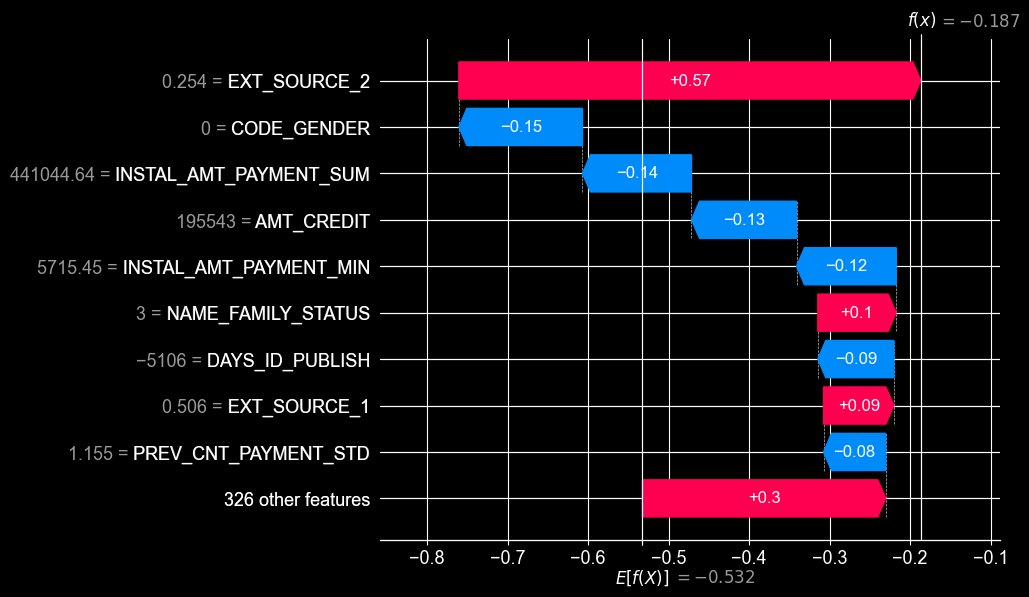

EXPLICATION DE LA PRÉDICTION - Client 2
Prédiction: Pas de défaut
Probabilité de défaut: 0.4535

Top 10 features influençant la prédiction:
------------------------------------------------------------
EXT_SOURCE_2                   =       0.57
  Impact SHAP: +0.5738 ↑ Augmente le risque

CODE_GENDER                    =       1.00
  Impact SHAP: -0.1535 ↓ Diminue le risque

INSTAL_AMT_PAYMENT_SUM         = 2973171.69
  Impact SHAP: -0.1355 ↓ Diminue le risque

AMT_CREDIT                     = 1031053.50
  Impact SHAP: -0.1305 ↓ Diminue le risque

INSTAL_AMT_PAYMENT_MIN         =   10137.69
  Impact SHAP: -0.1238 ↓ Diminue le risque

NAME_FAMILY_STATUS             =       1.00
  Impact SHAP: +0.0974 ↑ Augmente le risque

DAYS_ID_PUBLISH                =    -331.00
  Impact SHAP: -0.0945 ↓ Diminue le risque

EXT_SOURCE_1                   =       0.51
  Impact SHAP: +0.0874 ↑ Augmente le risque

PREV_CNT_PAYMENT_STD           =      11.62
  Impact SHAP: -0.0773 ↓ Diminue le risque

NAME

In [13]:
# Use the custom explainability function
print("Generating complete explainability report...")

# The function needs X_train and X_test, not y_test, feature_names, or model_name
report = create_explainability_report(
    model=model,
    X_train=X_train,
    X_test=X_test_sample,
    sample_indices=[0, 1, 2],
    output_dir='../reports/figures'
)

print("\nExplainability report generated!")
print("All visualizations saved to ../reports/figures/")

## 15. Export Critical Features List

In [14]:
# Save top features to CSV
feature_importance.head(50).to_csv('../reports/critical_features.csv', index=False)
print("Critical features saved to ../reports/critical_features.csv")

Critical features saved to ../reports/critical_features.csv


## 16. Business Recommendations

### Key Business Recommendations:

#### 1. Data Collection Priorities
Based on feature importance, prioritize collecting:
- External credit scores (EXT_SOURCE variables)
- Complete employment history
- Previous credit behavior patterns
- Income and asset information

#### 2. Red Flag Signals
Indicators that strongly predict default:
- Low external credit scores
- High credit amount relative to income
- Short employment duration
- Previous payment difficulties

#### 3. Risk Reduction Factors
Factors that reduce default probability:
- Higher external credit scores
- Stable employment history
- Lower debt-to-income ratio
- Good previous credit history

#### 4. Model Improvement Suggestions
- Add interaction features between key variables
- Collect more granular employment data
- Monitor feature drift in production
- A/B test different threshold strategies
- Consider ensemble methods combining multiple models

## Summary

This notebook has:
1. ✅ Loaded the champion model
2. ✅ Calculated SHAP values for global interpretability
3. ✅ Generated summary and importance plots
4. ✅ Analyzed local explanations for interesting cases
5. ✅ Provided business insights and recommendations

### Next Steps:
- Review all generated figures in `../reports/figures/`
- Proceed to `04_mlflow_serving_test.ipynb` for deployment testing